In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
%load_ext rpy2.ipython

#### Load the data
We load the preprocessed, trial data aligned to the start time. Trials are 4 seconds. 

In [2]:
# Load all the pupil data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/PAPERS/paper1_loss_aversion_pupil/eye_data/NARPS_MG_asc_processed"
pupil_data = []
for file in os.listdir(dir):
    if file.endswith("timeseries_start.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        pupil_data.append(csv)
pupil_data = pd.concat(pupil_data)

# Remove trials with nan values (these are trials that were too short)
pupil_data["sub_trial"] = pupil_data["sub"].astype(str) + "_" + pupil_data["trial"].astype(str)
nan_sub_trial = pupil_data[pupil_data["ps_preprocessed"].isna()]["sub_trial"].unique()
pupil_data = pupil_data[~pupil_data["sub_trial"].isin(nan_sub_trial)]
pupil_data["outofbounds"] = pupil_data["outofbounds"].fillna(False)

# Load the behavioral data
behav = pd.read_csv("../../data/behavioral_data.csv")

# Merge behav and pupil_data
data = pupil_data.merge(behav, on=["sub", "trial"])
# remove RT < 0.2 and response_int.isna()
data = data.query("RT > 0.2")

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_58546/2830066672.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pupil_data["outofbounds"] = pupil_data["outofbounds"].fillna(False)


#### Plot the pupil data for each condition

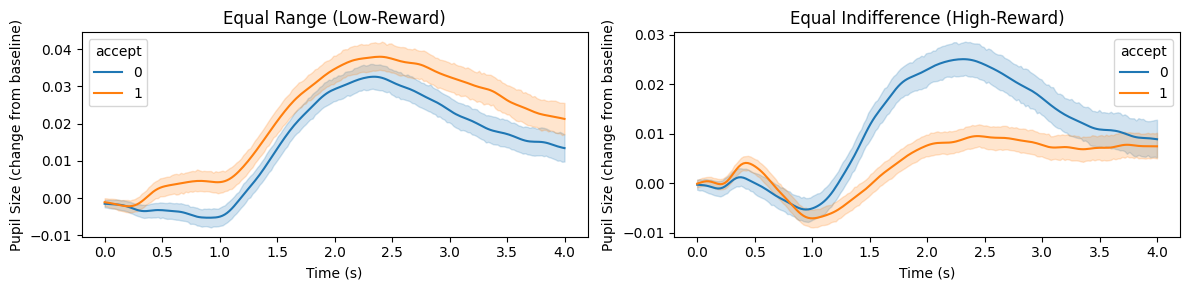

In [3]:
# Create subplot with 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Equal Range plot
sns.lineplot(data=data.query("condition == 'equalRange'"), 
            x='timebin', y='ps_preprocessed', hue='accept', ax=ax1)
ax1.set_title('Equal Range (Low-Reward)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pupil Size (change from baseline)')

# Equal Indifference plot  
sns.lineplot(data=data.query("condition == 'equalIndifference'"), 
            x='timebin', y='ps_preprocessed', hue='accept', ax=ax2)
ax2.set_title('Equal Indifference (High-Reward)') 
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pupil Size (change from baseline)')

plt.tight_layout()
plt.show()

#### Modeling timebins of pupil size
We will model the pupil size as a function of the accept, blink, and condition. We want to observe the effect of the accept, gain, and loss on pupil size. Furthermore, we want to eliminate the effect of blink and condition

In [4]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [5]:
%%R
# loop through timebins
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed predicted by accept*condition + blink*condition + (sub|1)
    model = lmer(ps_preprocessed ~ gain*condition + loss*condition + accept*condition + blink*condition + (1|sub), data=data[data$timebin == tb, ])
    # model = lmer(ps_preprocessed ~ accept*condition +loss*condition + gain*condition + blink*condition + (1|sub), data=data[data$timebin == tb, ])
    # save the coefficients and pvalues in a list
    fixed_effects <- summary(model)$coefficients
    # Loop through fixed effects
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
    }
}

In [6]:
%%R -o all_sub_pupil_coef
# put them into a dataframe
all_sub_pupil_coef <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues)

In [7]:
timebins = all_sub_pupil_coef['timebin'].unique()
gain_HR = all_sub_pupil_coef.query("name == 'gain'")['estimate'].values
loss_HR = all_sub_pupil_coef.query("name == 'loss'")['estimate'].values
accept_HR = all_sub_pupil_coef.query("name == 'accept'")['estimate'].values
gain_LR = all_sub_pupil_coef.query("name == 'gain:conditionequalRange'")['estimate'].values + gain_HR
loss_LR = all_sub_pupil_coef.query("name == 'conditionequalRange:loss'")['estimate'].values + loss_HR
accept_LR = all_sub_pupil_coef.query("name == 'conditionequalRange:accept'")['estimate'].values + accept_HR
gain_HR_pvalue = all_sub_pupil_coef.query("name == 'gain'")['pvalue'].values
loss_HR_pvalue = all_sub_pupil_coef.query("name == 'loss'")['pvalue'].values
accept_HR_pvalue = all_sub_pupil_coef.query("name == 'accept'")['pvalue'].values
gain_LR_pvalue = all_sub_pupil_coef.query("name == 'gain:conditionequalRange'")['pvalue'].values
loss_LR_pvalue = all_sub_pupil_coef.query("name == 'conditionequalRange:loss'")['pvalue'].values
accept_LR_pvalue = all_sub_pupil_coef.query("name == 'conditionequalRange:accept'")['pvalue'].values


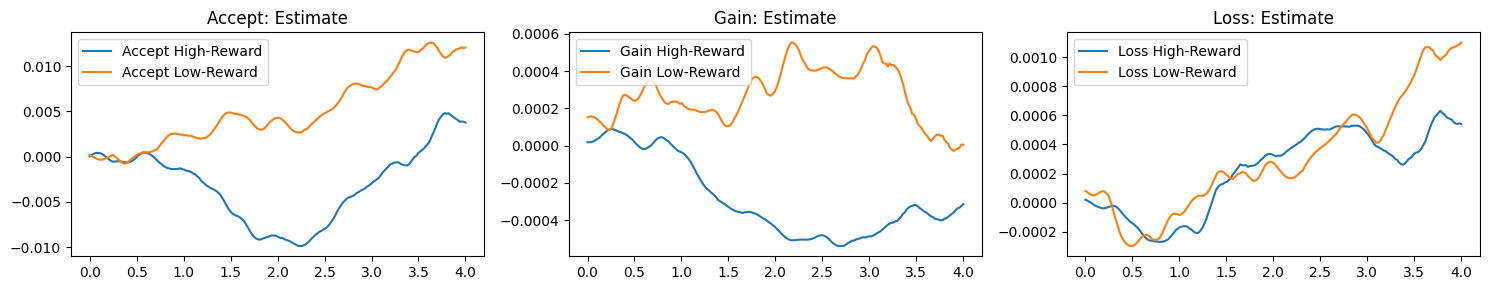

In [8]:
# Make three plots, for accept, gain and loss across conditions
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].plot(timebins, accept_HR, label='Accept High-Reward')
axs[0].plot(timebins, accept_LR, label='Accept Low-Reward')
axs[0].set_title('Accept: Estimate')
axs[0].legend()
axs[1].plot(timebins, gain_HR, label='Gain High-Reward')
axs[1].plot(timebins, gain_LR, label='Gain Low-Reward')
axs[1].set_title('Gain: Estimate')
axs[1].legend()
axs[2].plot(timebins, loss_HR, label='Loss High-Reward')
axs[2].plot(timebins, loss_LR, label='Loss Low-Reward')
axs[2].set_title('Loss: Estimate')
axs[2].legend()
plt.tight_layout()
plt.show()

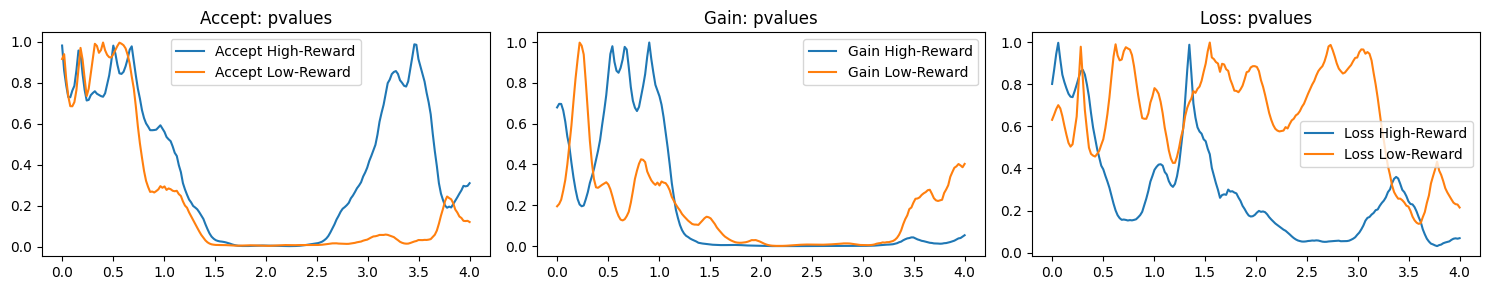

In [9]:
# Make three plots, for accept, gain and loss across conditions pvalues
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].plot(timebins, accept_HR_pvalue, label='Accept High-Reward')
axs[0].plot(timebins, accept_LR_pvalue, label='Accept Low-Reward')
axs[0].set_title('Accept: pvalues')
axs[0].legend()
axs[1].plot(timebins, gain_HR_pvalue, label='Gain High-Reward')
axs[1].plot(timebins, gain_LR_pvalue, label='Gain Low-Reward')
axs[1].set_title('Gain: pvalues')
axs[1].legend()
axs[2].plot(timebins, loss_HR_pvalue, label='Loss High-Reward')
axs[2].plot(timebins, loss_LR_pvalue, label='Loss Low-Reward')
axs[2].set_title('Loss: pvalues')
axs[2].legend()
plt.tight_layout()
plt.show()

**Findings:**
- The pupil response is higher when accepting a gamble in the low-reward condition than in the high-reward condition (where it decreases).
    - This is significant 1.5 seconds to 2.5 seconds after the start of the trial. 
- The pupil response is lower for larger gains and higher for larger losses in the high-reward condition. 
    - This is significant 2 seconds to 3 seconds after the start of the trial. 

#### Relation of pupil response to behavior
What is the source of the pupil response? For each subject, compute the estimate of the accept, gain, and loss for each timebin from 2-2.5 seconds after the start of the trial. 

In [10]:
%%R
# loop through timebins FOR ACCEPT
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
sub_list <- c()
for (tb in unique(data$timebin)) {
    # skip tb lower than 1.3 and higher than 1.5
    if (tb < 2 | tb > 2.05) {
        next
    }
    # loop through each sub
    for (sub in unique(data$sub)) {
        # for each timebin, run a linear mixed effects model of ps_preprocessed predicted by accept*condition + blink*condition + (sub|1)
        model = lm(ps_preprocessed ~ accept + gain + loss + blink, data=data[data$timebin == tb & data$sub == sub, ])
        # save the coefficients and pvalues in a list
        fixed_effects <- summary(model)$coefficients
        # Loop through fixed effects
        for (i in 1:nrow(fixed_effects)) {
            effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
            estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
            p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
            coefficient_pvalues <- c(coefficient_pvalues, p_value)
            coefficient_name <- c(coefficient_name, effect_name)
            coefficient_estimate <- c(coefficient_estimate, estimate)
            timebins <- c(timebins, tb)
            sub_list <- c(sub_list, sub)
        }
    }
}

In [11]:
%%R -o sub_pupil_coef
# put them into a dataframe
sub_pupil_coef <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues,
                            sub = sub_list)

In [12]:
sub_pupil_coef = sub_pupil_coef.query("name == 'accept' | name == 'gain' | name == 'loss'").groupby(['sub', 'name'])['estimate'].mean().reset_index()

In [13]:
# Load the data for DDM fits
all_params_fit = pd.read_csv("../../data/ddm_fits.csv")[["param_name", "mean", "sub", "condition"]]
# We will include lambda as a parameter, which is the ratio of the drift rate towards gain to the drift rate towards loss
lmbda = {}
lmbda["param_name"] = "lambda"
lmbda["mean"] = np.abs(all_params_fit.query("param_name == 'v_loss'")["mean"].values / all_params_fit.query("param_name == 'v_gain'")["mean"].values)
lmbda["sub"] = all_params_fit.query("param_name == 'v_loss'")["sub"].values
lmbda["condition"] = all_params_fit.query("param_name == 'v_loss'")["condition"].values
lmbda = pd.DataFrame(lmbda)
all_params_fit = pd.concat([all_params_fit, lmbda])

# Load the data for accept rates
behav_data = pd.read_csv('../../data/behavioral_data.csv')
accept_rate = behav_data.groupby(["sub", "condition"])["accept"].mean().reset_index()
accept_rate = accept_rate.merge(all_params_fit, on=["sub", "condition"])

In [14]:
# sort accept rate by sub
accept_rate = accept_rate.sort_values(by="sub")
sub_pupil_coef = sub_pupil_coef.sort_values(by="sub")

In [15]:
for param1 in sub_pupil_coef["name"].unique():
    for param2 in accept_rate["param_name"].unique():
        p = stats.pearsonr(sub_pupil_coef.query(f"name == '{param1}'")["estimate"].values, accept_rate.query(f"param_name == '{param2}'")["mean"].values)
        if p.pvalue < 0.05:
            print(param1, param2)
            print(p)

accept z
PearsonRResult(statistic=np.float64(-0.36063647374833535), pvalue=np.float64(0.0073859891261902596))
accept v_loss
PearsonRResult(statistic=np.float64(-0.29203981072566), pvalue=np.float64(0.03213041308550049))
gain v_gain
PearsonRResult(statistic=np.float64(0.3471436749041827), pvalue=np.float64(0.010116889293583028))
loss z
PearsonRResult(statistic=np.float64(0.2698746341710151), pvalue=np.float64(0.04843306273851086))


**Findings:**
- The results for the response aligned pupil are stronger, but still follow from the start aligned. 

In [16]:
acceptance_sub = accept_rate.groupby("sub")["accept"].mean().reset_index()["accept"].values
for param in sub_pupil_coef["name"].unique():
    p = stats.pearsonr(sub_pupil_coef.query(f"name == '{param}'")["estimate"].values, acceptance_sub)
    if p.pvalue < 0.05:
        print(param)
        print(p)

accept
PearsonRResult(statistic=np.float64(-0.5668936893306381), pvalue=np.float64(7.856176492908268e-06))
gain
PearsonRResult(statistic=np.float64(-0.2769174761026471), pvalue=np.float64(0.042648471427656105))


**Findings:** 
- As previous research has found, the pupil response is correlated with the probability of accepting a gamble. 

#### Relation between estimate of accept and probability of accepting a gamble


In [17]:
results = pd.DataFrame({"acceptance": acceptance_sub, "estimate": sub_pupil_coef.query("name == 'accept'")["estimate"].values, "sub" : sub_pupil_coef.query("name == 'accept'")["sub"].values})

# behav_data has the conditions for each sub
behav_data.groupby("sub")["condition"].unique()
# get the condition for each unique sub
sub_cond = behav_data[["sub", "condition"]].drop_duplicates().reset_index(drop=True)
results = results.merge(sub_cond, on="sub")

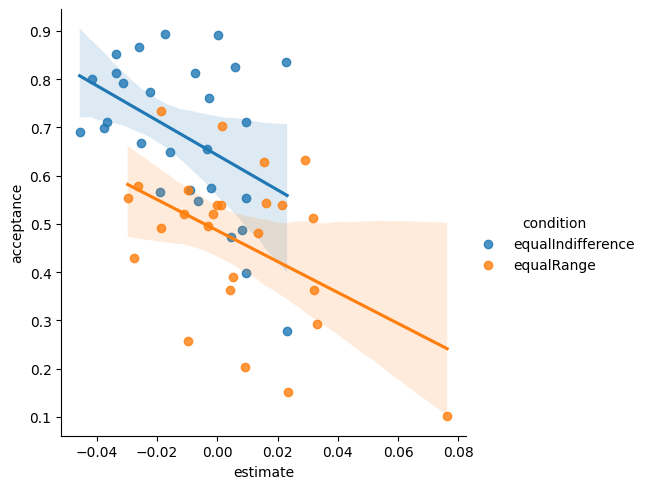

In [18]:
sns.lmplot(data=results, x='estimate', y='acceptance', hue='condition')
plt.show()
